In [117]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

Set random seed for reproducibility


In [118]:
torch.manual_seed(42)
np.random.seed(42)

Device configuration


In [119]:
device = "mps"
print(f"Using device: {device}")

Using device: mps


Load and prepare data


In [120]:
data = pd.read_csv("./data/rnn_full_data.csv")

Create a unique location identifier and time key


In [121]:
data["time_key"] = data["Year"] * 12 + data["Month"]
data = (
    data.groupby(["time_key", "District"])
    .agg({"crime_count": "sum", "Year": "first", "Month": "first"})
    .reset_index()
)
data["sin_month"] = np.sin(2 * np.pi * (data["Month"] - 1) / 12)
data["cos_month"] = np.cos(2 * np.pi * (data["Month"] - 1) / 12)
data

,time_key,District,crime_count,Year,Month,sin_month,cos_month
0,24241,1.0,1054.0,2020,1,0.0,1.000000
1,24241,2.0,795.0,2020,1,0.0,1.000000
2,24241,3.0,1028.0,2020,1,0.0,1.000000
3,24241,4.0,1074.0,2020,1,0.0,1.000000
4,24241,5.0,874.0,2020,1,0.0,1.000000
...,...,...,...,...,...,...,...
1375,24300,20.0,383.0,2024,12,-0.5,0.866025
1376,24300,22.0,564.0,2024,12,-0.5,0.866025
1377,24300,24.0,598.0,2024,12,-0.5,0.866025
1378,24300,25.0,1002.0,2024,12,-0.5,0.866025


Get unique locations and time points


In [122]:
locations = data["District"].unique()
locations.sort()
n_location = len(locations)
time_points = sorted(data["time_key"].unique())
n_time = len(time_points)
location_map = {location: i for i, location in enumerate(locations)}
time_map = {time_point: i for i, time_point in enumerate(time_points)}
data["district_id"] = data["District"].map(location_map)
data["time_id"] = data["time_key"].map(time_map)
print(location_map)
print(time_map)

{np.float64(1.0): 0, np.float64(2.0): 1, np.float64(3.0): 2, np.float64(4.0): 3, np.float64(5.0): 4, np.float64(6.0): 5, np.float64(7.0): 6, np.float64(8.0): 7, np.float64(9.0): 8, np.float64(10.0): 9, np.float64(11.0): 10, np.float64(12.0): 11, np.float64(14.0): 12, np.float64(15.0): 13, np.float64(16.0): 14, np.float64(17.0): 15, np.float64(18.0): 16, np.float64(19.0): 17, np.float64(20.0): 18, np.float64(22.0): 19, np.float64(24.0): 20, np.float64(25.0): 21, np.float64(31.0): 22}
{np.int64(24241): 0, np.int64(24242): 1, np.int64(24243): 2, np.int64(24244): 3, np.int64(24245): 4, np.int64(24246): 5, np.int64(24247): 6, np.int64(24248): 7, np.int64(24249): 8, np.int64(24250): 9, np.int64(24251): 10, np.int64(24252): 11, np.int64(24253): 12, np.int64(24254): 13, np.int64(24255): 14, np.int64(24256): 15, np.int64(24257): 16, np.int64(24258): 17, np.int64(24259): 18, np.int64(24260): 19, np.int64(24261): 20, np.int64(24262): 21, np.int64(24263): 22, np.int64(24264): 23, np.int64(24265): 

In [123]:
print(f"Number of unique locations: {len(locations)}")
print(f"Number of time points: {len(time_points)}")
data

Number of unique locations: 23
Number of time points: 60


,time_key,District,crime_count,Year,Month,sin_month,cos_month,district_id,time_id
0,24241,1.0,1054.0,2020,1,0.0,1.000000,0,0
1,24241,2.0,795.0,2020,1,0.0,1.000000,1,0
2,24241,3.0,1028.0,2020,1,0.0,1.000000,2,0
3,24241,4.0,1074.0,2020,1,0.0,1.000000,3,0
4,24241,5.0,874.0,2020,1,0.0,1.000000,4,0
...,...,...,...,...,...,...,...,...,...
1375,24300,20.0,383.0,2024,12,-0.5,0.866025,18,59
1376,24300,22.0,564.0,2024,12,-0.5,0.866025,19,59
1377,24300,24.0,598.0,2024,12,-0.5,0.866025,20,59
1378,24300,25.0,1002.0,2024,12,-0.5,0.866025,21,59


In [124]:
features = ["district_id", "crime_count"]
input_size = len(features) - 1
matrix = np.zeros((len(time_points), len(locations), input_size + 1))

In [125]:
for _, row in data.iterrows():
    location_id = round(row["district_id"])
    time_id = round(row["time_id"])
    matrix[time_id, location_id] = row[features]
matrix.shape

(60, 23, 2)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

train_size = int(0.8 * len(matrix))
scaler_crime = MinMaxScaler()
scaler = MinMaxScaler()
matrix_scaled = matrix.copy()
matrix_scaled[:train_size, :, input_size] = scaler_crime.fit_transform(
    matrix_scaled[:train_size, :, input_size].reshape(-1, 1)
).reshape(train_size, len(locations))
matrix_scaled[train_size:, :, input_size] = scaler_crime.transform(
    matrix_scaled[train_size:, :, input_size].reshape(-1, 1)
).reshape(len(time_points) - train_size, len(locations))
if input_size > 1:
    matrix_scaled[:train_size, :, 1:input_size] = scaler.fit_transform(
        matrix_scaled[:train_size, :, 1:input_size].reshape(-1, input_size - 1)
    ).reshape(train_size, len(locations), input_size - 1)
    matrix_scaled[train_size:, :, 1:input_size] = scaler.transform(
        matrix_scaled[train_size:, :, 1:input_size].reshape(-1, input_size - 1)
    ).reshape(len(time_points) - train_size, len(locations), input_size - 1)

In [127]:
seq_length = 12

In [128]:
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i : i + seq_length]
        target = data[i + seq_length, :, -1]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

Create sequences


In [129]:
X, y = create_sequences(matrix_scaled, seq_length)
print(X.shape)
print(y.shape)

(48, 12, 23, 2)
(48, 23)


In [130]:
print(f"Number of sequences: {len(X)}")
print(
    f"Input shape: {X.shape}"
)  # [n_sequences, sequence_length, n_locations, n_features]
print(f"Target shape: {y.shape}")  # [n_sequences, n_locations]

Number of sequences: 48
Input shape: (48, 12, 23, 2)
Target shape: (48, 23)


In [131]:
X_train, X_val = X[: train_size - seq_length], X[train_size - seq_length :]
y_train, y_val = y[: train_size - seq_length], y[train_size - seq_length :]

In [132]:
print(f"Training sequences: {len(X_train)}")
print(f"Validation sequences: {len(X_val)}")

Training sequences: 36
Validation sequences: 12


Convert to PyTorch tensors


In [133]:
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
X_val_tensor = torch.FloatTensor(X_val).to(device)
y_val_tensor = torch.FloatTensor(y_val).to(device)

Define the RNN model


In [134]:
hidden_size = 32
batch_size = 4
num_layers = 2
embed_dim = 23
output_size = 1
num_epochs = 50

In [135]:
class CrimeLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, embed_dim, num_layers, output_size):
        super(CrimeLSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.location_embedding = nn.Embedding(len(locations), embed_dim)
        self.lstm = nn.LSTM(
            input_size=input_size + embed_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
        )
        self.fc1 = nn.Linear(hidden_size, 64)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(64, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        # x: [seq_length, batch_size, n_features (crime_count, location_id)]

        batch_size = x.size(1)
        h_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        c_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

        # location_embed: [seq_length, batch_size, embed_dim]
        location_embed = self.location_embedding(x[:, :, 0].long())
        # crime: [seq_length, batch_size, 1]
        num_feat = x[:, :, 1:]
        # Combine num_feat and location embeddings
        x = torch.cat((num_feat, location_embed), dim=-1)
        # x: [seq_length, batch_size, embed_dim + 1]
        output, (_, _) = self.lstm(x, (h_0, c_0))
        output = self.fc1(output[-1])
        output = self.relu(output)
        output = self.dropout(output)
        output = self.fc2(output)

        return output

In [136]:
print(X_train.shape)
model = CrimeLSTM(input_size, hidden_size, embed_dim, num_layers, output_size).to(
    device
)
print(model)

(36, 12, 23, 2)
CrimeLSTM(
  (location_embedding): Embedding(23, 23)
  (lstm): LSTM(24, 32, num_layers=2)
  (fc1): Linear(in_features=32, out_features=64, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)


Define loss function and optimizer


In [137]:
criterion = nn.MSELoss()

Training function


In [138]:
# Validation
def evaluate_model(model, X_val_tensor, y_val_tensor):
    model.eval()
    val_loss = 0
    num_batches = 0
    with torch.no_grad():
        for i in range(len(X_val)):
            for batch in range(0, n_location, batch_size):
                sequence = X_train_tensor[i, :, batch : batch + batch_size]
                target = y_train_tensor[i, batch : batch + batch_size]
                score = model(sequence)
                loss = criterion(score, target.unsqueeze(1))
                val_loss += loss.item()
                num_batches += 1
    total_val_loss = val_loss / num_batches
    return total_val_loss

In [139]:
start_time = time.time()
n_location = len(locations)
train_losses = []
val_losses = []
my_lr = 0.001
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    num_batches = 0
    my_lr = my_lr * 0.9
    optimizer = torch.optim.Adam(model.parameters(), lr=my_lr)
    for i in range(len(X_train)):
        for batch in range(0, n_location, batch_size):
            optimizer.zero_grad()
            sequence = X_train_tensor[i, :, batch : batch + batch_size]
            target = y_train_tensor[i, batch : batch + batch_size]
            score = model(sequence)
            loss = criterion(score, target.unsqueeze(1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            num_batches += 1
    train_loss /= num_batches
    train_losses.append(train_loss)
    val_loss = evaluate_model(model, X_val_tensor, y_val_tensor)
    val_losses.append(val_loss)

    print(
        f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.12f}, Val Loss: {val_loss:.12f}, learning rate: {my_lr:.6f}, time: {time.time() - start_time:.2f} seconds"
    )

Epoch [1/50], Train Loss: 0.022745381416, Val Loss: 0.015434512266, learning rate: 0.000900, time: 1.86 seconds
Epoch [2/50], Train Loss: 0.008145155071, Val Loss: 0.018643603046, learning rate: 0.000810, time: 3.50 seconds
Epoch [3/50], Train Loss: 0.007311397457, Val Loss: 0.014799428161, learning rate: 0.000729, time: 5.18 seconds
Epoch [4/50], Train Loss: 0.007661352499, Val Loss: 0.014983617398, learning rate: 0.000656, time: 7.07 seconds
Epoch [5/50], Train Loss: 0.007599644515, Val Loss: 0.016038400674, learning rate: 0.000590, time: 9.04 seconds
Epoch [6/50], Train Loss: 0.008453005945, Val Loss: 0.018076763451, learning rate: 0.000531, time: 10.98 seconds
Epoch [7/50], Train Loss: 0.008498924911, Val Loss: 0.018091851638, learning rate: 0.000478, time: 12.93 seconds
Epoch [8/50], Train Loss: 0.008609929989, Val Loss: 0.026160585571, learning rate: 0.000430, time: 14.82 seconds
Epoch [9/50], Train Loss: 0.010154299020, Val Loss: 0.023002056185, learning rate: 0.000387, time: 16

Train the model


Plot training and validation loss


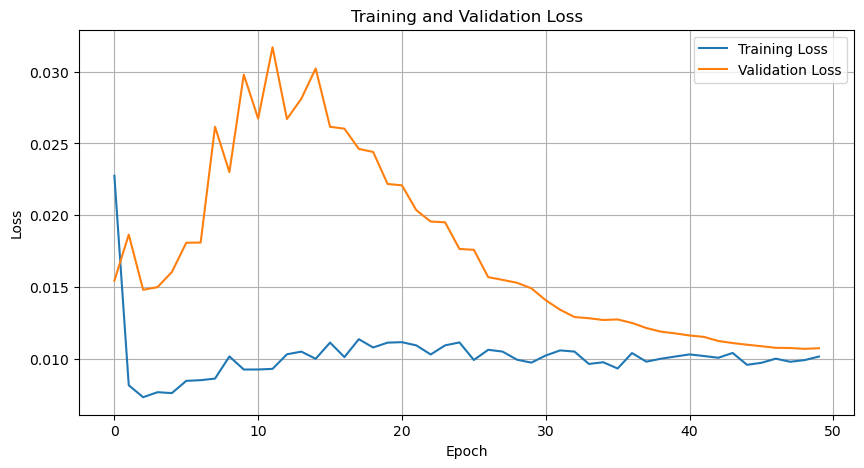

In [140]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.savefig("training_validation_loss.pdf")
plt.show()

In [141]:
def predictions(model, X, y):
    num_seq, _, n_location, n_features = X.shape
    result = np.zeros((num_seq, n_location, 2))
    with torch.no_grad():
        for i in range(num_seq):
            for batch in range(0, n_location, batch_size):
                plus = batch_size
                if batch + batch_size > n_location:
                    plus = n_location - batch
                sequence = X[i, :, batch : batch + plus]
                target = y[i, batch : batch + plus]
                score = model(sequence)
                result[i, batch : batch + plus, 0] = score.cpu().flatten()
                result[i, batch : batch + plus, 1] = target.cpu()
    return result

In [142]:
prediction_model = model.to("mps")
result = predictions(model, X_val_tensor.to("mps"), y_val_tensor.to("mps"))
unscaled_result = scaler_crime.inverse_transform(result.reshape(-1, 1)).reshape(
    result.shape[0], result.shape[1], 2
)
unscaled_result[0]

/var/folders/sx/pmvfmfnd1yb2twxrjn65_p0m0000gn/T/ipykernel_27918/1553825516.py:13: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  result[i, batch : batch + plus, 0] = score.cpu().flatten()
/var/folders/sx/pmvfmfnd1yb2twxrjn65_p0m0000gn/T/ipykernel_27918/1553825516.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  result[i, batch : batch + plus, 1] = target.cpu()


array([[1014.25436884, 1075.00003278],
       [ 969.50569749,  987.99996823],
       [ 988.28734457, 1039.99997675],
       [1142.35070348, 1066.00002944],
       [ 824.69484955,  812.00002134],
       [1214.01376277, 1137.99995929],
       [ 869.18907613,  789.99999166],
       [1230.3834632 , 1245.99999934],
       [ 868.33372712,  851.99996084],
       [ 831.7233175 ,  841.00004286],
       [1116.91465229, 1073.9999786 ],
       [1148.70388061, 1137.00000197],
       [ 678.59787866,  736.99997738],
       [ 672.34286666,  620.99998817],
       [ 735.20961404,  713.99999037],
       [ 573.51334766,  568.00002232],
       [ 994.61117387, 1043.99999976],
       [ 983.87897015,  919.00000721],
       [ 412.06668317,  449.00001585],
       [ 635.3873536 ,  570.99999115],
       [ 679.49134111,  805.99998683],
       [1020.54081112, 1027.00004727],
       [   6.75978512,    3.00000004]])

In [143]:
rounded_result = np.round(unscaled_result)
rounded_result

array([[[1.014e+03, 1.075e+03],
        [9.700e+02, 9.880e+02],
        [9.880e+02, 1.040e+03],
        [1.142e+03, 1.066e+03],
        [8.250e+02, 8.120e+02],
        [1.214e+03, 1.138e+03],
        [8.690e+02, 7.900e+02],
        [1.230e+03, 1.246e+03],
        [8.680e+02, 8.520e+02],
        [8.320e+02, 8.410e+02],
        [1.117e+03, 1.074e+03],
        [1.149e+03, 1.137e+03],
        [6.790e+02, 7.370e+02],
        [6.720e+02, 6.210e+02],
        [7.350e+02, 7.140e+02],
        [5.740e+02, 5.680e+02],
        [9.950e+02, 1.044e+03],
        [9.840e+02, 9.190e+02],
        [4.120e+02, 4.490e+02],
        [6.350e+02, 5.710e+02],
        [6.790e+02, 8.060e+02],
        [1.021e+03, 1.027e+03],
        [7.000e+00, 3.000e+00]],

       [[1.013e+03, 1.094e+03],
        [9.690e+02, 9.870e+02],
        [9.880e+02, 1.038e+03],
        [1.142e+03, 1.092e+03],
        [8.250e+02, 8.020e+02],
        [1.214e+03, 1.128e+03],
        [8.690e+02, 7.910e+02],
        [1.230e+03, 1.346e+03],
      

In [144]:
month_result = np.sum(rounded_result, axis=1)
month_result

array([[19611., 19518.],
       [19601., 19889.],
       [19594., 20853.],
       [19593., 20394.],
       [19592., 22905.],
       [19596., 23086.],
       [19605., 23991.],
       [19616., 22825.],
       [19618., 22786.],
       [19619., 22282.],
       [19621., 19522.],
       [19612., 19269.]])

Overall RMSE: 120.57
Overall MAE: 101.49
Overall MAE Percentage: 24.08%


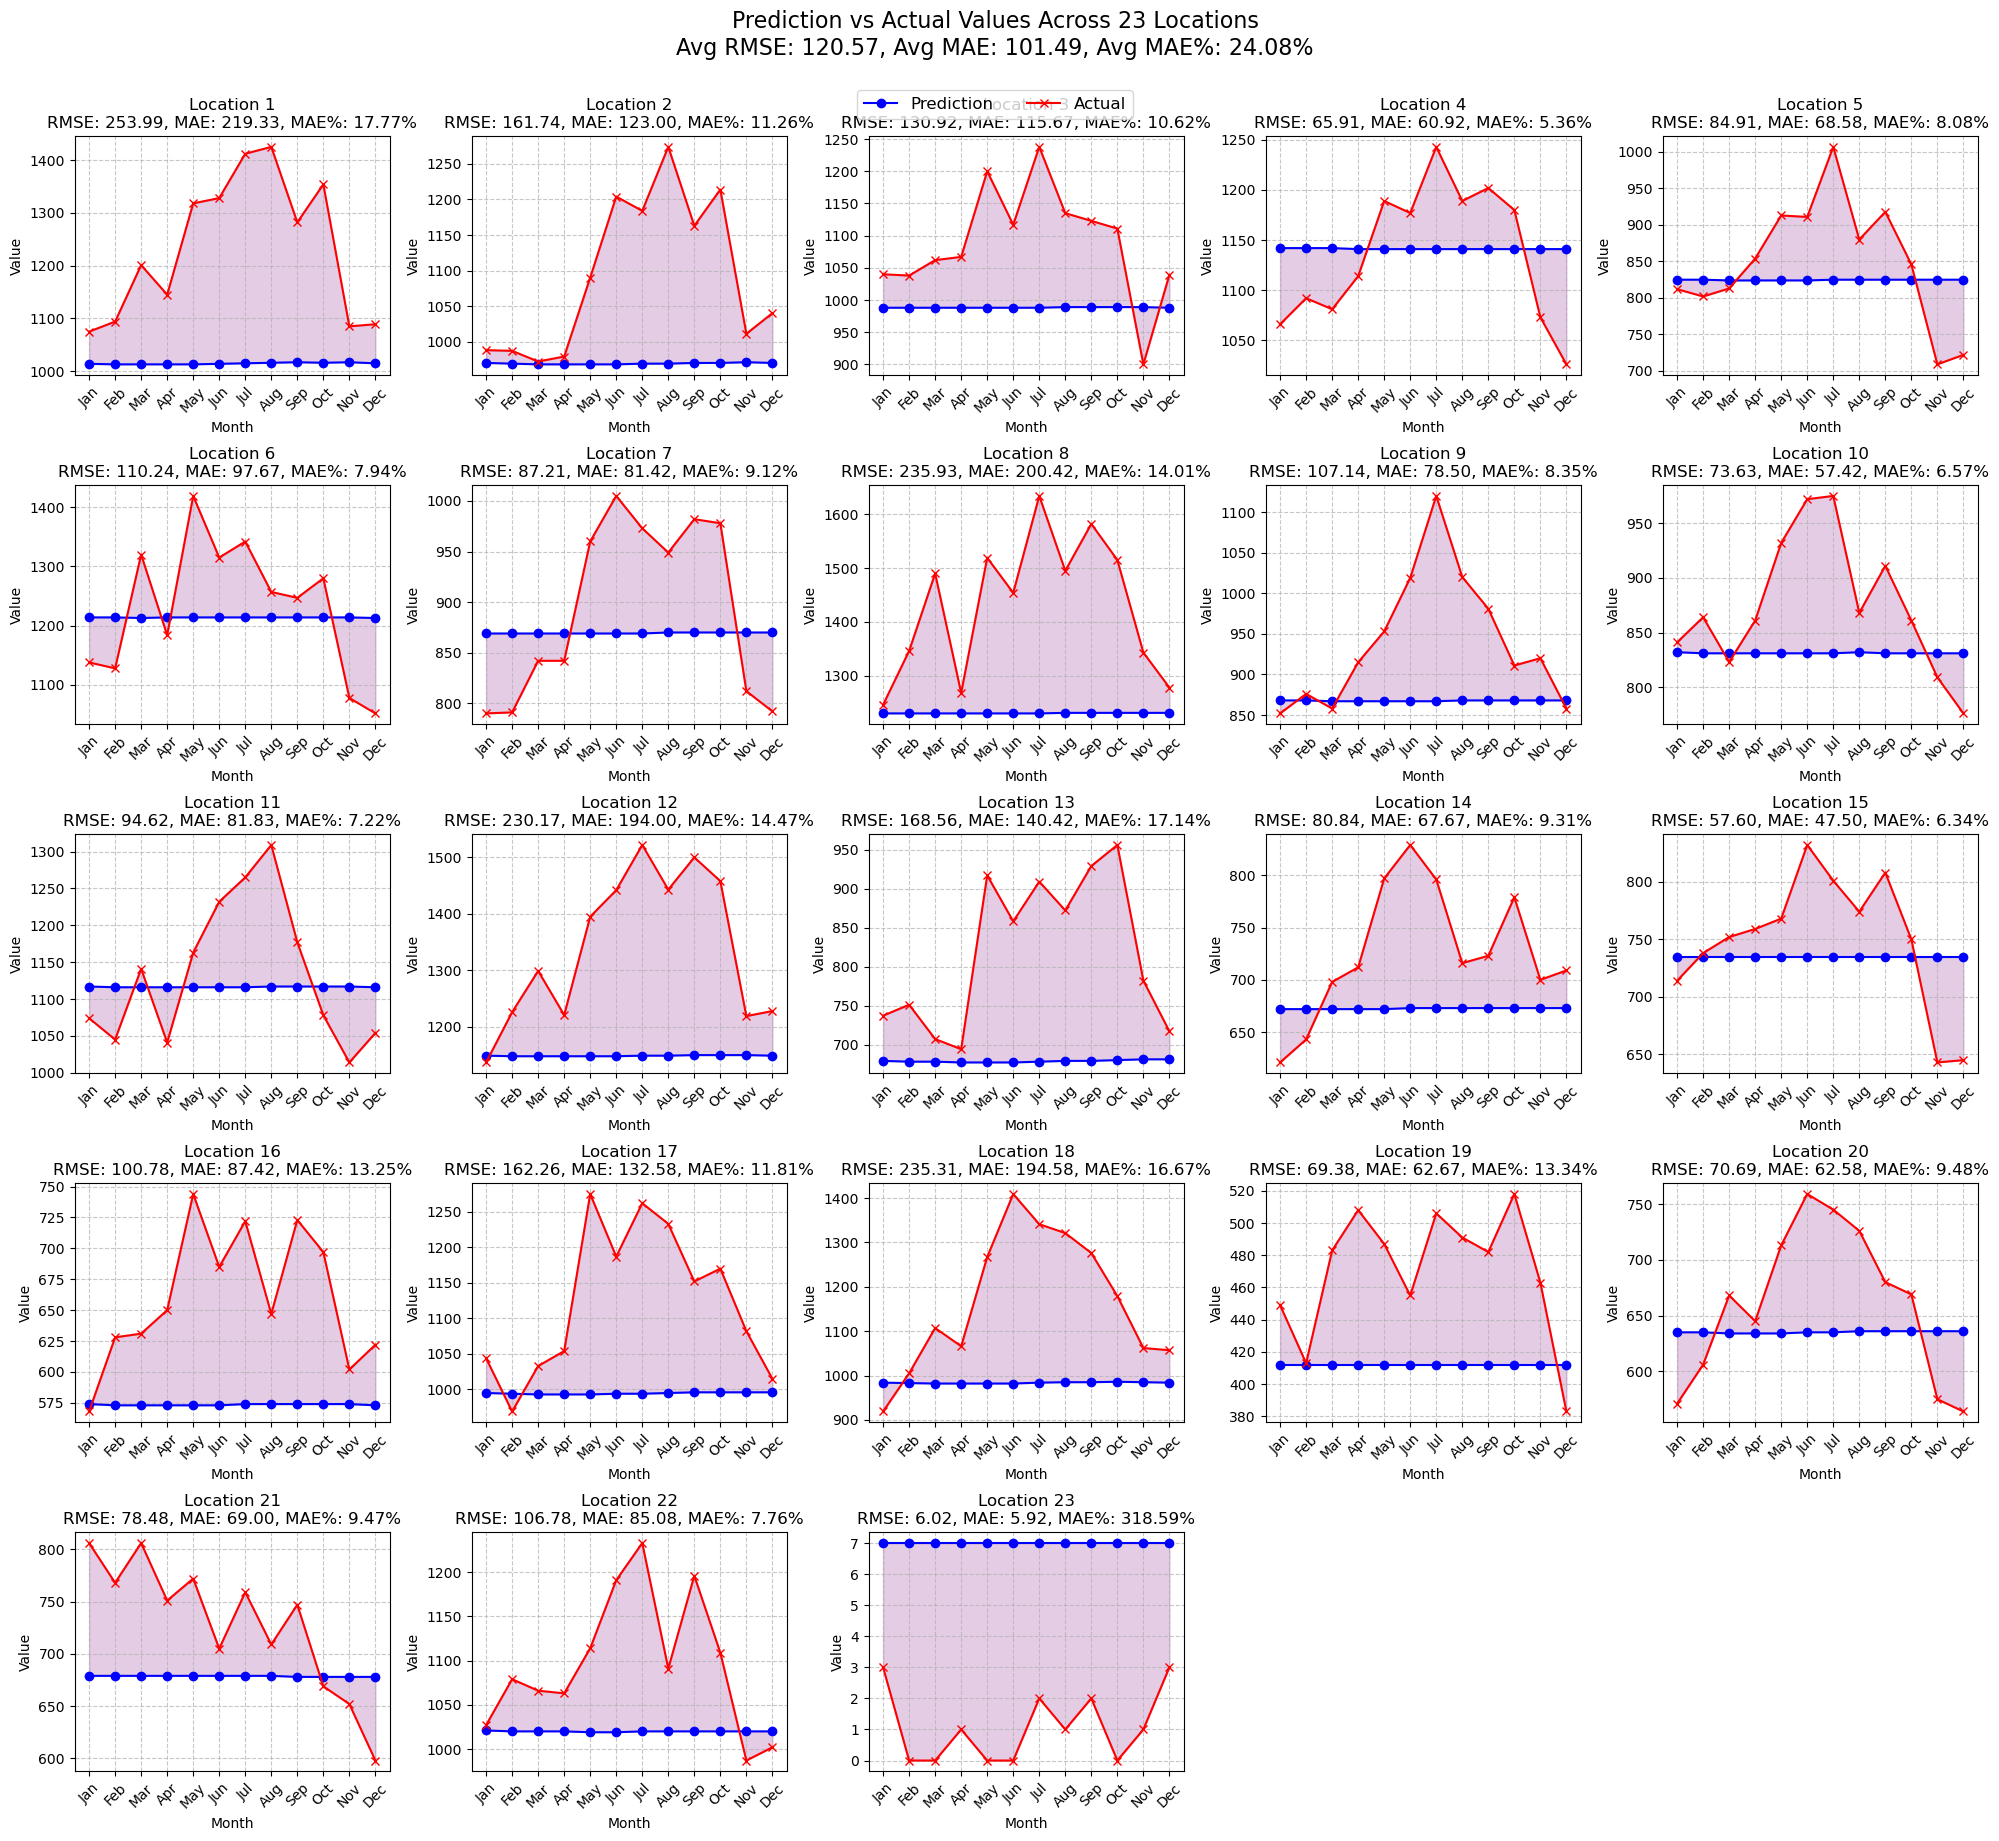

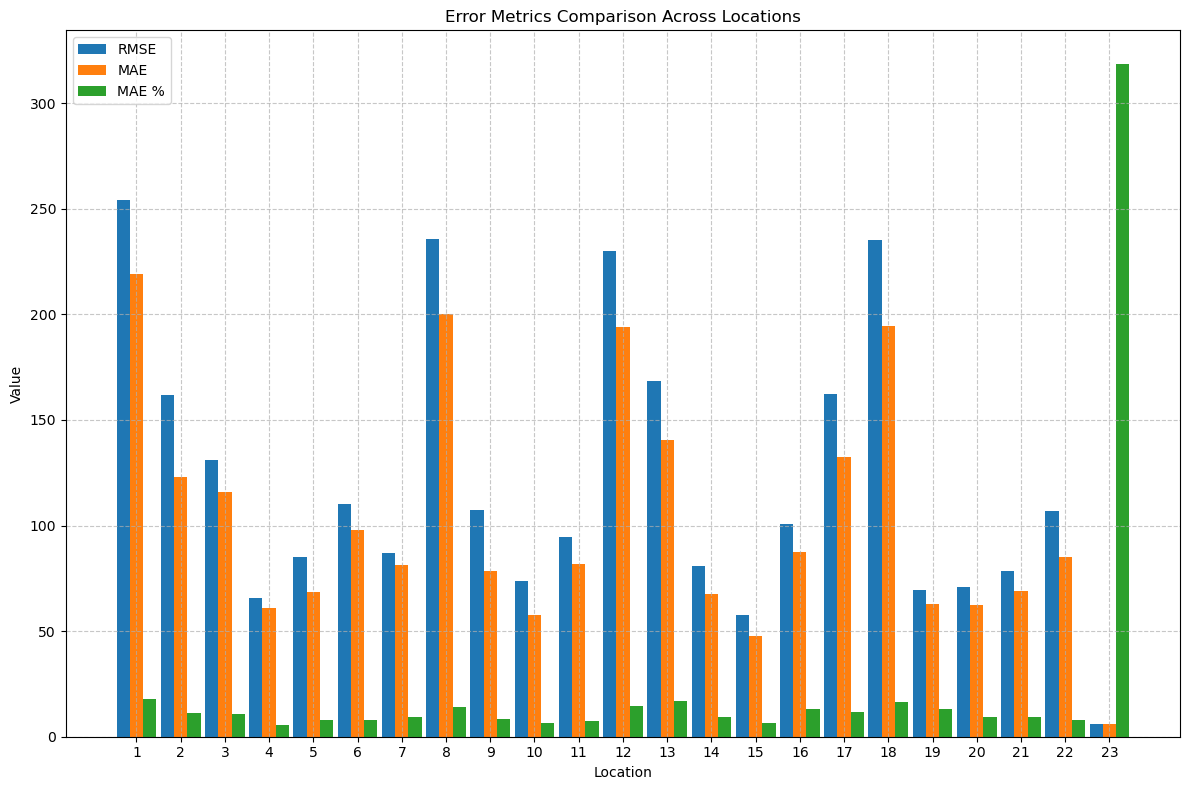

In [145]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming rounded_result is already defined with shape (12, 23, 2)
# Create figure with subplots
# We'll create a 5x5 grid to accommodate 23 locations (with some empty spaces)
fig, axes = plt.subplots(5, 5, figsize=(20, 18))
axes = axes.flatten()

# Set up month names for x-axis
months = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]

# Create arrays to store metrics for each location
rmse_values = np.zeros(23)
mae_values = np.zeros(23)
mae_percentage_values = np.zeros(23)

# Plot each location in a separate subplot
for loc in range(23):
    ax = axes[loc]

    # Extract data for this location
    predictions = rounded_result[:, loc, 0]
    actuals = rounded_result[:, loc, 1]

    # Calculate metrics for this location
    # RMSE (Root Mean Square Error)
    rmse = np.sqrt(np.mean((predictions - actuals) ** 2))
    rmse_values[loc] = rmse

    # MAE (Mean Absolute Error)
    mae = np.mean(np.abs(predictions - actuals))
    mae_values[loc] = mae

    # MAE as percentage of actual values - with handling for zeros
    # Calculate the mean of absolute actuals but exclude zeros to avoid division by zero
    mean_abs_actual = (
        np.mean(np.abs(actuals[actuals != 0])) if np.any(actuals != 0) else 1.0
    )
    mae_percentage = (mae / mean_abs_actual) * 100
    mae_percentage_values[loc] = mae_percentage

    # Plot both prediction and actual values
    ax.plot(months, predictions, "o-", color="blue", label="Prediction")
    ax.plot(months, actuals, "x-", color="red", label="Actual")

    # Fill between the two lines to highlight differences
    ax.fill_between(months, predictions, actuals, alpha=0.2, color="purple")

    # Set title and labels with metrics
    ax.set_title(
        f"Location {loc+1}\nRMSE: {rmse:.2f}, MAE: {mae:.2f}, MAE%: {mae_percentage:.2f}%"
    )
    ax.set_xlabel("Month")
    ax.set_ylabel("Value")

    # Set grid
    ax.grid(True, linestyle="--", alpha=0.7)

    # Rotate x-axis labels for better readability
    ax.tick_params(axis="x", rotation=45)

# Hide empty subplots
for i in range(23, 25):
    axes[i].axis("off")

# Add legend to the figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels, loc="upper center", bbox_to_anchor=(0.5, 0.98), ncol=2, fontsize=12
)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(top=0.95)

# Calculate average metrics across all locations
avg_rmse = np.mean(rmse_values)
avg_mae = np.mean(mae_values)
avg_mae_percentage = np.mean(mae_percentage_values)

plt.suptitle(
    f"Prediction vs Actual Values Across 23 Locations\n"
    f"Avg RMSE: {avg_rmse:.2f}, Avg MAE: {avg_mae:.2f}, Avg MAE%: {avg_mae_percentage:.2f}%",
    fontsize=16,
    y=1.02,
)

# Print overall metrics
print(f"Overall RMSE: {avg_rmse:.2f}")
print(f"Overall MAE: {avg_mae:.2f}")
print(f"Overall MAE Percentage: {avg_mae_percentage:.2f}%")

# Create a separate figure for metrics comparison across locations
plt.figure(figsize=(12, 8))
x = np.arange(23) + 1  # Location numbers

width = 0.3
plt.bar(x - width, rmse_values, width, label="RMSE")
plt.bar(x, mae_values, width, label="MAE")
plt.bar(x + width, mae_percentage_values, width, label="MAE %")

plt.xlabel("Location")
plt.ylabel("Value")
plt.title("Error Metrics Comparison Across Locations")
plt.xticks(x)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

RMSE: 2453.98
MAE: 1926.00
R²: -1.2773
MAPE: 8.50%


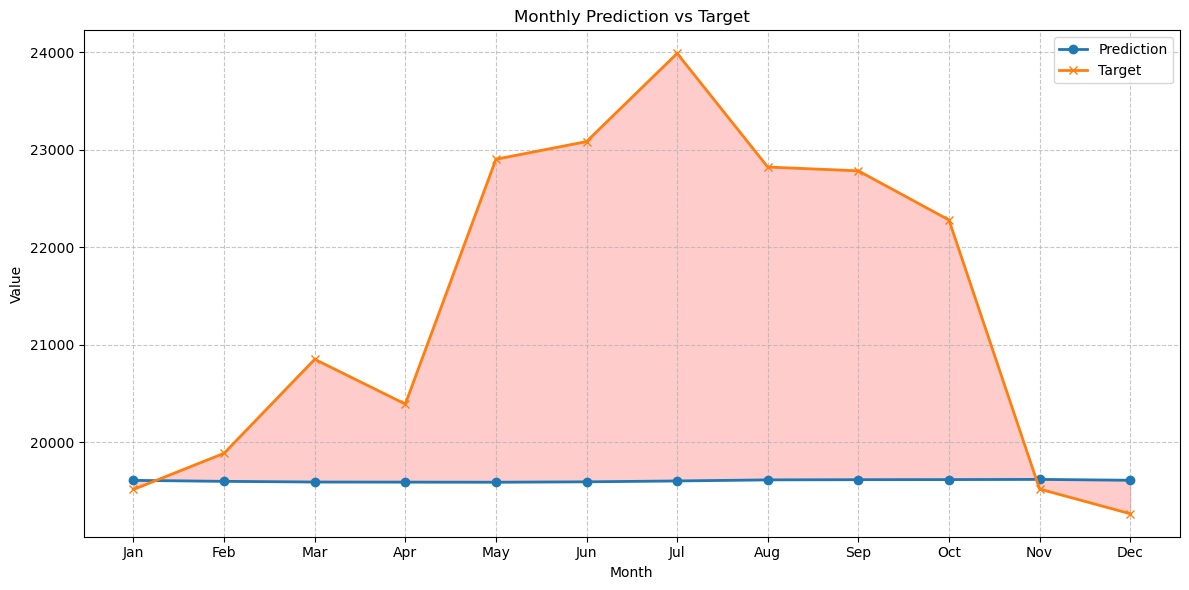


Additional Error Analysis:
Minimum absolute error: 93.00
Maximum absolute error: 4386.00
Average error (bias): -1836.83
Standard deviation of error: 1627.29

Best performing month: Jan with absolute error of 93.00
Worst performing month: Jul with absolute error of 4386.00


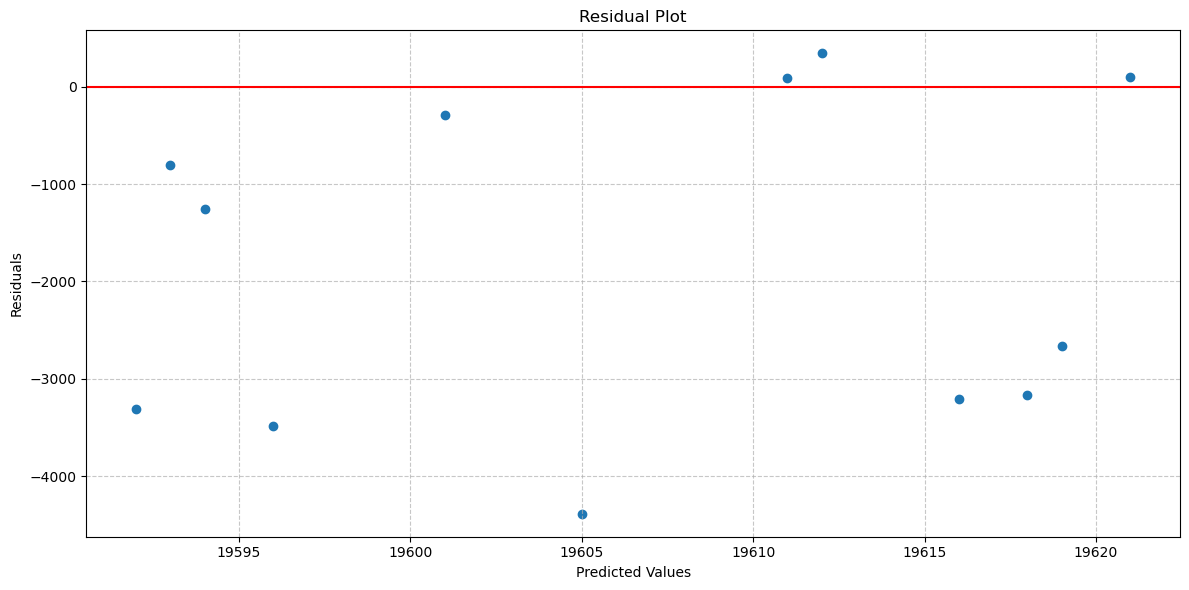

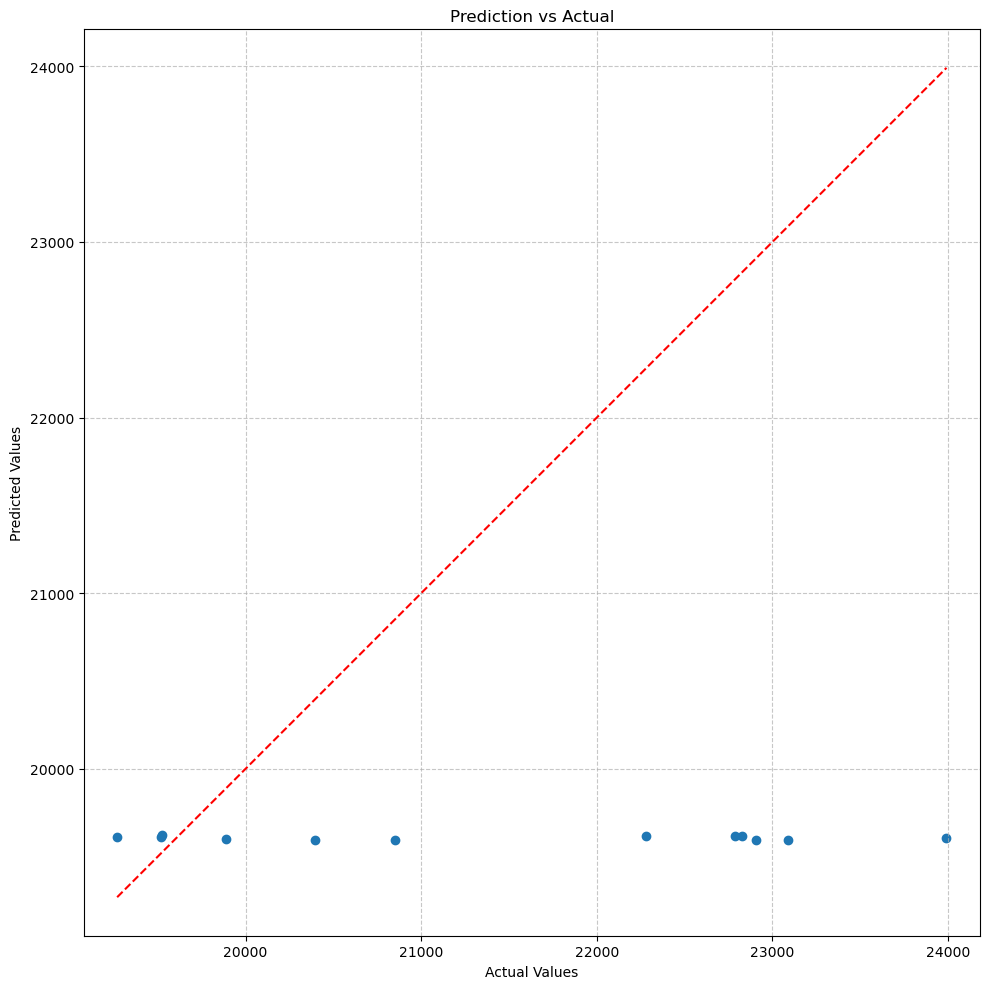

In [146]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

predictions = month_result[:, 0]
targets = month_result[:, 1]

# Calculate performance metrics
rmse = np.sqrt(mean_squared_error(targets, predictions))
mae = mean_absolute_error(targets, predictions)
r2 = r2_score(targets, predictions)
mape = np.mean(np.abs((targets - predictions) / targets)) * 100

# Print metrics
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")

# Create months for x-axis
months = list(range(1, 13))
month_names = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]

# Plot monthly results
plt.figure(figsize=(12, 6))
plt.plot(months, predictions, marker="o", label="Prediction", linewidth=2)
plt.plot(months, targets, marker="x", label="Target", linewidth=2)
plt.fill_between(months, predictions, targets, alpha=0.2, color="red")
plt.grid(True, linestyle="--", alpha=0.7)
plt.xlabel("Month")
plt.ylabel("Value")
plt.title("Monthly Prediction vs Target")
plt.xticks(months, month_names)
plt.legend()
plt.tight_layout()

# Optional: Save the plot
# plt.savefig('monthly_prediction_vs_target.png', dpi=300)

# Display the plot
plt.show()

# Calculate additional statistics
min_error = np.min(np.abs(predictions - targets))
max_error = np.max(np.abs(predictions - targets))
avg_error = np.mean(predictions - targets)
std_error = np.std(predictions - targets)

print(f"\nAdditional Error Analysis:")
print(f"Minimum absolute error: {min_error:.2f}")
print(f"Maximum absolute error: {max_error:.2f}")
print(f"Average error (bias): {avg_error:.2f}")
print(f"Standard deviation of error: {std_error:.2f}")

# Monthly error analysis
monthly_abs_errors = np.abs(predictions - targets)
worst_month_idx = np.argmax(monthly_abs_errors)
best_month_idx = np.argmin(monthly_abs_errors)

print(
    f"\nBest performing month: {month_names[best_month_idx]} with absolute error of {monthly_abs_errors[best_month_idx]:.2f}"
)
print(
    f"Worst performing month: {month_names[worst_month_idx]} with absolute error of {monthly_abs_errors[worst_month_idx]:.2f}"
)


# If we assume rounded_result is available and has shape [months, locations]
# Here's code to visualize it as a heatmap
def plot_rounded_result(rounded_result):
    plt.figure(figsize=(12, 8))
    plt.imshow(rounded_result, cmap="viridis", aspect="auto")
    plt.colorbar(label="Value")
    plt.xlabel("Location")
    plt.ylabel("Month")
    plt.title("Heatmap of Values by Month and Location")
    plt.yticks(range(len(month_names)), month_names)
    plt.tight_layout()
    plt.show()

    # Calculate statistics per location
    location_means = np.mean(rounded_result, axis=0)
    location_stds = np.std(rounded_result, axis=0)

    print("\nLocation Statistics:")
    for i, (mean, std) in enumerate(zip(location_means, location_stds)):
        print(f"Location {i+1}: Mean = {mean:.2f}, Std = {std:.2f}")


# Uncomment and use this to plot rounded_result if available
# plot_rounded_result(rounded_result)

# Create residual plot
plt.figure(figsize=(12, 6))
residuals = predictions - targets
plt.scatter(predictions, residuals)
plt.axhline(y=0, color="r", linestyle="-")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Create a prediction vs actual scatter plot with the identity line
plt.figure(figsize=(10, 10))
plt.scatter(targets, predictions)
plt.plot([min(targets), max(targets)], [min(targets), max(targets)], "r--")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Prediction vs Actual")
plt.axis("equal")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [147]:
last_12 = data.copy()
last_12[last_12["Year"] == 2024]

,time_key,District,crime_count,Year,Month,sin_month,cos_month,district_id,time_id
1104,24289,1.0,1075.0,2024,1,0.0,1.000000,0,48
1105,24289,2.0,988.0,2024,1,0.0,1.000000,1,48
1106,24289,3.0,1040.0,2024,1,0.0,1.000000,2,48
1107,24289,4.0,1066.0,2024,1,0.0,1.000000,3,48
1108,24289,5.0,812.0,2024,1,0.0,1.000000,4,48
...,...,...,...,...,...,...,...,...,...
1375,24300,20.0,383.0,2024,12,-0.5,0.866025,18,59
1376,24300,22.0,564.0,2024,12,-0.5,0.866025,19,59
1377,24300,24.0,598.0,2024,12,-0.5,0.866025,20,59
1378,24300,25.0,1002.0,2024,12,-0.5,0.866025,21,59


In [148]:
last_12 = last_12[last_12["Year"] == 2024]
last_12.groupby(["Month"]).agg({"crime_count": "sum"}).reset_index()

,Month,crime_count
0,1,19518.0
1,2,19889.0
2,3,20853.0
3,4,20394.0
4,5,22905.0
5,6,23086.0
6,7,23991.0
7,8,22825.0
8,9,22786.0
9,10,22282.0


In [149]:
y_val.sum(axis=1)

array([12.01107692, 12.23938462, 12.83261538, 12.55015385, 14.09538462,
       14.20676923, 14.76369231, 14.04615385, 14.02215385, 13.712     ,
       12.01353846, 11.85784615])